# Fourier slice integration

In [9]:
import jax.numpy as jnp

import cryojax.simulator as cxs
from cryojax.io import read_atoms_from_pdb


atom_positions, atom_identities = read_atoms_from_pdb("./data/5w0s.pdb")
atom_potential = cxs.PengAtomicPotential(atom_positions, atom_identities)

In [3]:
# Evaluate the potential on a voxel grid
shape = (240, 240, 240)
voxel_size = 1.0
real_voxel_grid = atom_potential.as_real_voxel_grid(
    shape,
    voxel_size,
    z_planes_in_parallel=10,
)

In [4]:
from cryojax.image import downsample_with_fourier_cropping


downsampling_factor = 3
downsampled_voxel_size = downsampling_factor * voxel_size
downsampled_voxel_grid = downsample_with_fourier_cropping(
    real_voxel_grid, downsampling_factor
)
potential = cxs.FourierVoxelGridPotential.from_real_voxel_grid(
    downsampled_voxel_grid, downsampled_voxel_size
)

In [5]:
from cryojax.image import irfftn


potential_integrator = cxs.FourierSliceExtraction(interpolation_order=1)
instrument_config = cxs.InstrumentConfig(
    shape=potential.shape[0:2],
    pixel_size=potential.voxel_size,
    voltage_in_kilovolts=300.0,
)
fourier_integrated_potential = potential_integrator.compute_fourier_integrated_potential(
    potential, instrument_config
)
projection = irfftn(fourier_integrated_potential, s=instrument_config.shape)

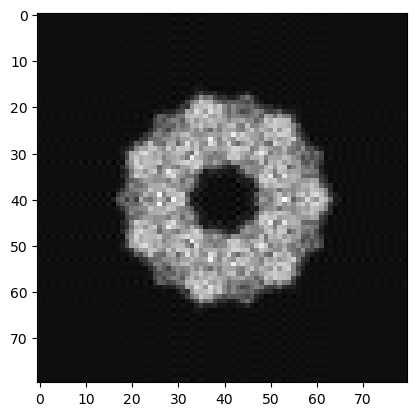

In [6]:
import matplotlib.pyplot as plt


plt.imshow(projection, cmap="gray")

# Multislice integrator

In [106]:
downsampling_factor = 3
downsampled_voxel_size = downsampling_factor * voxel_size
downsampled_voxel_grid = downsample_with_fourier_cropping(
    real_voxel_grid, downsampling_factor
)
potential = cxs.RealVoxelGridPotential.from_real_voxel_grid(
    downsampled_voxel_grid, downsampled_voxel_size
)

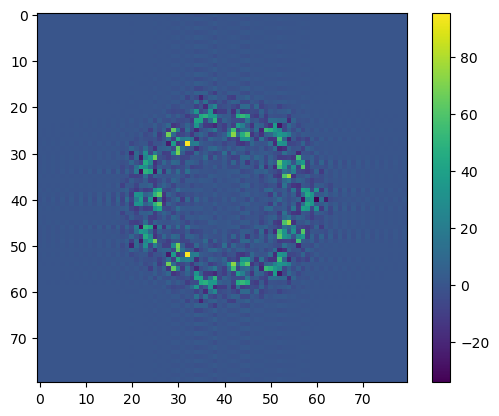

In [124]:
plt.imshow(potential.real_voxel_grid[40])
plt.colorbar()

In [108]:
instrument_config = cxs.InstrumentConfig(
    shape=potential.shape[0:2],
    pixel_size=potential.voxel_size,
    voltage_in_kilovolts=300.0,
)

In [109]:
dir(instrument_config)

['__abstractclassvars__',
 '__abstractmethods__',
 '__abstractvars__',
 '__annotations__',
 '__check_init__',
 '__class__',
 '__dataclass_fields__',
 '__dataclass_params__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__match_args__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 'coordinate_grid_in_angstroms',
 'coordinate_grid_in_pixels',
 'crop_or_pad_to_padded_shape',
 'crop_to_shape',
 'electrons_per_angstrom_squared',
 'frequency_grid_in_angstroms',
 'frequency_grid_in_pixels',
 'full_frequency_grid_in_angstroms',
 'full_frequency_grid_in_pixels',
 'n_pixels',
 'pad_mode',
 'pad_to_padded_shape',
 'padded_coordinate_grid_in_angstroms',
 'padded_coordinate_grid_in_pixels',
 'padded_frequency_grid_in_ang

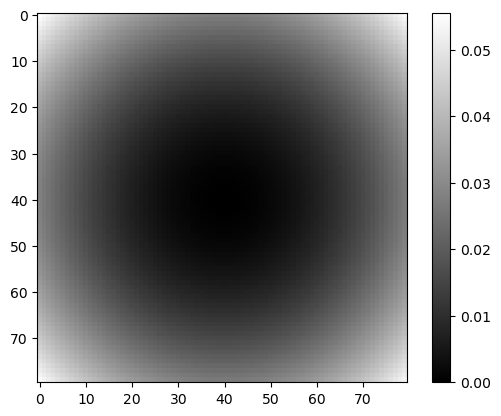

In [119]:
kx, ky = instrument_config.padded_full_frequency_grid_in_angstroms.T
k2 = jnp.hypot(kx, ky) ** 2
plt.imshow(jnp.fft.fftshift(k2), cmap="gray")
plt.colorbar()

In [125]:
from typing_extensions import override

from jaxtyping import Array, Complex

from cryojax.image import fftn, ifftn
from cryojax.simulator._instrument_config import InstrumentConfig
from cryojax.simulator._multislice_integrator import AbstractMultisliceIntegrator


class MultisliceIntegrator(
    AbstractMultisliceIntegrator[cxs.RealVoxelGridPotential],
    strict=True,
):
    @override
    def compute_wavefunction_at_exit_plane(
        self,
        potential: cxs.RealVoxelGridPotential,
        instrument_config: InstrumentConfig,
    ) -> Complex[
        Array, "{instrument_config.padded_y_dim} {instrument_config.padded_x_dim}"
    ]:
        delta_z = 1.0
        real_slices = potential.real_voxel_grid
        shape = potential.shape[1:]
        # TODO: interpolate for different slice thicknesses
        plane_wave_n = jnp.ones(shape, dtype=complex)
        sigma = (
            instrument_config.wavelength_in_angstroms / (4 * jnp.pi)
        )  # see https://github.com/mjo22/cryojax/blob/multislice-updated/src/cryojax/simulator/_scattering_theory/common_functions.py
        transmission = jnp.exp(1j * sigma * real_slices)
        kx, ky = instrument_config.padded_full_frequency_grid_in_angstroms.T
        k2_origin_corner = jnp.hypot(kx, ky) ** 2  # TODO: shift to origin at centre
        k2_origin_center = jnp.fft.fftshift(k2_origin_corner)
        fresnel_propagator = jnp.exp(
            -1j
            * jnp.pi
            * instrument_config.wavelength_in_angstroms
            * k2_origin_center
            * delta_z
            * potential.voxel_size
        )
        plane_wave_ns = jnp.zeros((len(real_slices), *shape), dtype=complex)
        for n in range(len(transmission)):
            tn = transmission[n]
            t_psi_f = fftn(tn * plane_wave_n)
            # t_psi_f_shift = jnp.fft.fftshift(t_psi_f)
            plane_wave_ns = plane_wave_ns.at[n].set(
                ifftn(
                    t_psi_f * fresnel_propagator
                )  # TODO: skip last one (move to top of loop)
            )
        exit_wave = plane_wave_ns[-1]  # TODO: return fourier space

        return exit_wave

```python
class MultiSliceIntegrator(AbstractPotentialIntegrator, strict=True):
    delta_z: int = field(static=True, default=1)  # pixels
    sigma: int = field(static=True, default=1)  # TODO: get from config

    def __call__(
        self,
        potential: RealVoxelGridPotential,
        wavelength_in_angstroms: Float[Array, ""],
        config: ImageConfig,
    ) -> Complex[Array, "{config.padded_y_dim} {config.padded_x_dim}"]:
        real_slices = potential.real_voxel_grid
        shape = real_slices.shape[1:]
        real_slices = real_slices.reshape(-1, self.delta_z, *shape).sum(1)

        plane_wave_n = jnp.ones(shape, dtype=complex)

        transmission = jnp.exp(1j * self.sigma * real_slices)
        # delta_z = config.voxel_size
        # voxel_size = 1
        # config = cxs.ImageConfig(shape=shape, pixel_size=voxel_size)
        kx, ky = (
            config.wrapped_frequency_grid_in_angstroms.array.T
        )  # TODO: not centered. see _coordinate_functions.make_frequencies
        k2 = jnp.hypot(kx, ky) ** 2
        # wavelength_in_angstroms = 0.001
        fresnel_propagator = jnp.exp(
            -1j
            * jnp.pi
            * wavelength_in_angstroms
            * k2
            * self.delta_z
            * config.voxel_size
        )

        plane_wave_ns = jnp.zeros((len(real_slices), *shape), dtype=complex)
        for n in range(len(transmission)):
            tn = transmission[n]
            t_psi_f = jnp.fft.fftn(tn * plane_wave_n)
            # t_psi_f_shift = jnp.fft.fftshift(t_psi_f)
            plane_wave_ns = plane_wave_ns.at[n].set(
                jnp.fft.ifftn(
                    t_psi_f * fresnel_propagator
                )  # TODO: skip last one (move to top of loop)
            )

        exit_wave = plane_wave_ns[-1]  # TODO: return fourier space
        return exit_wave
```     

In [126]:
multislice_integrator = MultisliceIntegrator()

multislice_integrator.compute_wavefunction_at_exit_plane(potential, instrument_config)

Array([[0.9999469 -0.01030413j, 0.9999468 -0.01031194j,
        0.9999468 -0.01030489j, ..., 0.9999468 -0.01031358j,
        0.99994695-0.01030331j, 0.9999468 -0.01031272j],
       [0.9999467 -0.01031191j, 0.9999467 -0.01030493j,
        0.9999468 -0.01031115j, ..., 0.9999467 -0.01030327j,
        0.9999468 -0.01031273j, 0.9999467 -0.01030414j],
       [0.9999469 -0.01030495j, 0.9999468 -0.01031111j,
        0.9999469 -0.01030572j, ..., 0.9999469 -0.01031277j,
        0.9999469 -0.01030413j, 0.9999468 -0.0103119j ],
       ...,
       [0.9999468 -0.01031358j, 0.9999467 -0.01030325j,
        0.9999468 -0.01031284j, ..., 0.9999467 -0.01030163j,
        0.9999468 -0.01031439j, 0.9999467 -0.01030248j],
       [0.9999469 -0.0103033j , 0.9999468 -0.01031277j,
        0.9999469 -0.01030406j, ..., 0.9999468 -0.01031441j,
        0.9999468 -0.01030249j, 0.9999467 -0.01031355j],
       [0.99994695-0.01031273j, 0.99994695-0.0103041j ,
        0.99994695-0.01031198j, ..., 0.9999469 -0.01030246j,
 

In [127]:
import cryojax.experimental as cxe


pose = cxs.EulerAnglePose(
    offset_x_in_angstroms=5.0,
    offset_y_in_angstroms=-3.0,
    view_phi=20.0,
    view_theta=80.0,
    view_psi=-5.0,
)
structural_ensemble = cxs.SingleStructureEnsemble(potential, pose)

wtf = cxe.WaveTransferFunction(
    defocus_in_angstroms=10000.0,
    astigmatism_in_angstroms=-100.0,
    astigmatism_angle=10.0,
    amplitude_contrast_ratio=0.1,
)
transfer_theory = cxe.WaveTransferTheory(wtf)

In [128]:
from cryojax.experimental import MultisliceScatteringTheory  # cxe


scattering_theory = MultisliceScatteringTheory(
    structural_ensemble, multislice_integrator, transfer_theory
)

In [129]:
imaging_pipeline = cxs.IntensityImagingPipeline(instrument_config, scattering_theory)

image = imaging_pipeline.render()

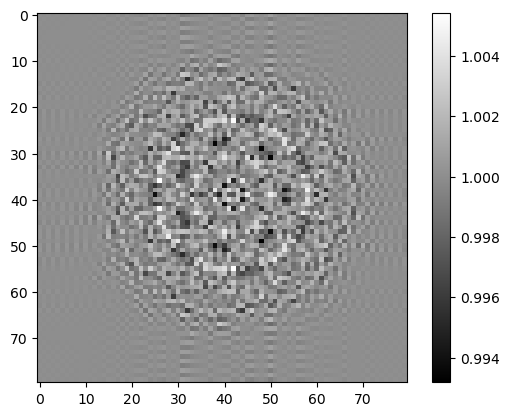

In [131]:
plt.imshow(image, cmap="gray")
plt.colorbar()